In [1]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx

import scipy.sparse as sp
import numpy as np

import torch

In [2]:
import os
import enum

# 相关数据集，仅含Cora
class DatasetType(enum.Enum):
    CORA = 0

# 图可视化工具库
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1
    
# 数据集路径
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')

# 数据集划分
CORA_TRAIN_RANGE = [0, 140]
CORA_VAL_RANGE = [140, 140 + 500]
CORA_TEST_RANGE = [1708, 1708 + 1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# 使用t-SNE降维或可视化时的节点颜色
cora_label_to_color_map = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'yellow', 5:'pink', 6:'gray'}

In [3]:
# cora数据集以pickle方式存储
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
    
    return data

def pickle_save(path, data):
    with open(path, 'rb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)  # protocol表示序列化模式，pickle.HIGHEST_PROTOCOL值为4

In [4]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Excepted a sparse matrix, got {node_features_sparse}.'
    
    # 使用矩阵特征逆和进行乘法,先求和
    node_features_sum = np.array(node_features_sparse.sum(-1))
    
    # 再取逆，因为乘1/x比直接除x快
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()
    
    # 将无效值设置为1
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.
    
    # 创建一个值为node_features_inv_sum的对角矩阵
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)
    
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

In [5]:
def build_edge_index(adj_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()
    
    for src_node, neighboring_nodes in adj_list_dict.items():
        for trg_node in neighboring_nodes:
            if (src_node, trg_node) not in seen_edges:
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)
                
                seen_edges.add((src_node, trg_node))
    
    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))
        
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))
    
    return edge_index

In [6]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Excepted NumPy array got {type(edge_index)}.'
    
    # 计算图的入度和出度
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    for src_id, trg_id in zip(edge_index[0], edge_index[1]):
        out_degrees[src_id] += 1
        in_degrees[trg_id] += 1
    
    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1
    
    # 画图
    fig = plt.figure(figsize=(12, 8), dpi=100)
    fig.subplots_adjust(hspace=0.6)
    
    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node idx')
    
    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Output degree for different node idx')
    
    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))
    
    plt.grid(True)
    plt.show()

In [7]:
def visualize_graph():
    pass

In [8]:
# 加载数据集
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']
    
    if dataset_name == DatasetType.CORA.name.lower():
        # shape = (N, M), N 为节点个数，M为节点特征个数
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # Shape = (N, N_neighbor)  <-这是一个字典，而不是矩阵
        adj_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))
        
        # 特征正则化，有助于模型训练
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)
        
        # shape = (2, E), E 为边的个数, 2 表示从源节点和目标节点
        topology = build_edge_index(adj_list_dict, num_of_nodes, add_self_edges=True)
        
        if should_visualize: # 绘制原图
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)
            visualize_graph(topology, node_labels_npy, dataset_name)
            
        # 将现有数据转换为pytorch张量格式
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)
        node_features = torch.tensor(node_features_csr.todense(), device=device)
        
        # 划分训练集、测试集、验证集,返回下标
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)
        
        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise  Exception(f'{dataset_name} not yet supported.')

## TEST1 Explore Core Dataset

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

C:\Users\pc\AppData\Local\Temp\ipykernel_14428\929043455.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(file)


torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


C:\Users\pc\AppData\Local\Temp\ipykernel_14428\626277400.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_degrees = np.zeros(num_of_nodes, dtype=np.int)
C:\Users\pc\AppData\Local\Temp\ipykernel_14428\626277400.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

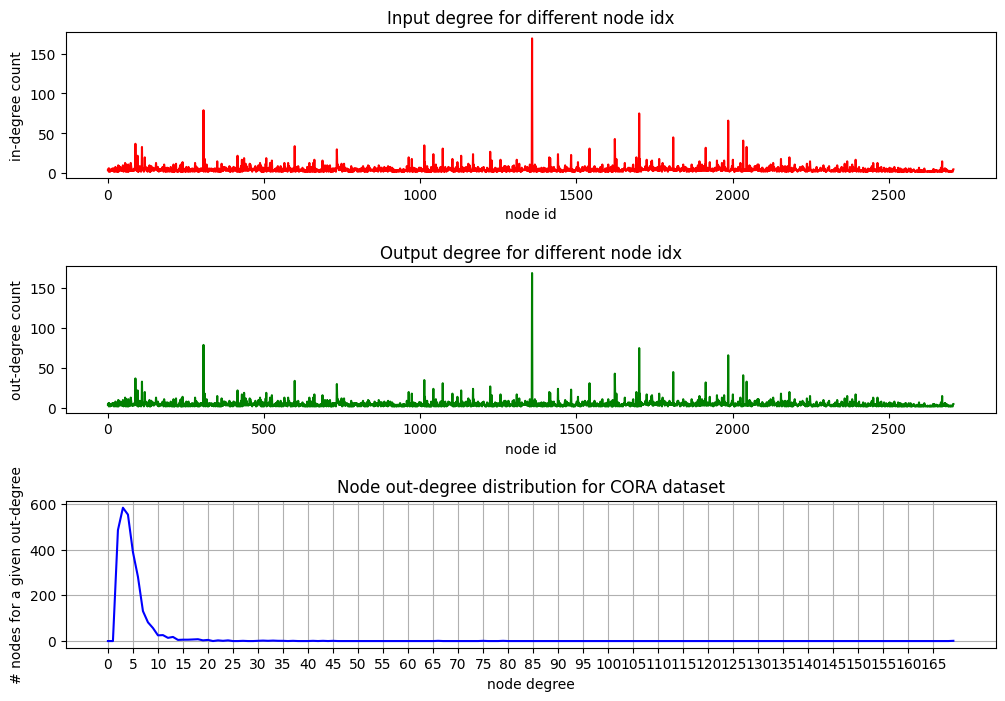

In [10]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [ ]:
import igraph as ig
dataset_name = config['dataset_name']
visualization_tool = GraphVisualizationTool.IGRAPH

# 调整为igraph格式
if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))

# 结构化igraph数
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# 准备可视化设置字典
visual_dict = {}

visual_dict['bbox'] = (1000, 1000)
visual_dict['margin'] = 5

# 设置边缘宽度
edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness()) + 1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_dict['edge_width'] = edge_weights

# 设置节点大小
visual_dict['vertex_size'] = [deg / 2 for deg in ig_graph.degree()]

# 设置节点颜色
visual_dict['vertex_color'] = [cora_label_to_color_map[label] for label in node_labels_np]
visual_dict['layout'] = ig_graph.layout_kamada_kawai()

print('Plotting results...')
ig.plot(ig_graph, **visual_dict)

## GAT

In [21]:
import torch.nn as nn
from torch.optim import Adam

In [31]:
class GAT(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'
        num_heads_per_layer = [1] + num_heads_per_layer
        
        gat_layers = []
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

## GAT layer

In [33]:
class GATLayer(torch.nn.Module):
    
    # 设置全局变量
    src_nodes_dim = 0
    trg_nodes_dim = 1
    
    nodes_dim = 0
    head_dim = 1
    
    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):
        super().__init__()
        
        self.num_of_heads = num_of_nodes  # 多头注意力的头数
        self.num_out_features = num_out_features  # 输出特征的维度
        self.concat = concat  # 输出方式
        self.add_skip_connection = add_skip_connection  
        
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        
        # 初始化权重
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features)) 
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features)) # 将偏移量设置为待学习的参数
        else:
            self.register_parameter('bias', None)  # 将偏移量置为0
        
        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)
        
        self.leakyReLU  = nn.LeakyReLU(0.2)
        self.activation = activation
        self.dropout    = nn.Dropout(p=dropout_prob)
        self.log_attention_weights = log_attention_weights  
        self.attention_weights = None
        
        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #
        
        in_nodes_features, edge_index = data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2
        
        in_nodes_features = self.dropout(in_nodes_features)
        
        # (N, FIN) * (FIN, NH * FOUT) -> (N, NH, FOUT)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)  # -1表示维度待定
        nodes_features_proj = self.dropout(nodes_features_proj)
        
        #
        # Step 2: Edge attention calculation
        #
        
        # (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH)
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)
        
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)
        
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        attentions_per_edge = self.dropout(attentions_per_edge)
        
        #
        # Step 3: Neighborhood aggregation
        #
        
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)
        
        #
        # Step 4: Residual/skip connections, concat and bias
        #
        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        
        return (out_nodes_features, edge_index)
    
    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        # ????
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()
        
        neighborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)
        attentions_per_edge = exp_scores_per_edge / (neighborhood_aware_denominator + 1e-16)
        
        return attentions_per_edge.unsqueeze(dim=-1)
    
    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # ????
        trg_index_broadcasted = self.explicit_broadcated(trg_index, exp_scores_per_edge)
        
        size = list[exp_scores_per_edge.shape]
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)
        
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)
    
    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        # ????
        size = list(nodes_features_proj_lifted_weighted)
        size[self.nodes_dim] = num_of_nodes
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)
        
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)
        
        return out_nodes_features
    
    def lift(self, scores_source, scores_target, node_features_matrix_proj, edge_index):
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]
        
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        node_features_matrix_proj_lifted = node_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)
        
        return scores_source, scores_target, node_features_matrix_proj_lifted
    
    def explicit_broadcast(self, this, other):
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)
            
        return this.expand_as(other)
    
    def init_params(self):
        nn.init.xavier_normal_(self.linear_proj.weight)
        nn.init.xavier_normal_(self.scoring_fn_target)
        nn.init.xavier_normal_(self.scoring_fn_source)
        
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)
            
    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:
            self.attention_weights = attention_coefficients
            
        if self.add_skip_connection:
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_out_heads, self.num_out_features)
        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)
        
        if self.bias is not None:
            out_nodes_features += self.bias
            
        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)